# Mortos no massacre de Gaza - 2023-2024

Voltar ao [índice](../00_indice.ipynb)

Neste notebook, ajustamos um modelo estatístico para descrever a distribuição de mortes em Gaza por 
idade e sexo decorrentes de ataques israelenses após o ataque do Hamas em 7 de outubro de 2023.

**Objetivos** 

Verificar a fração de mortes em Gaza que decorrem de ataques indiscriminados, que acertam toda a população 
(por ex., com bombas poderosas em áreas residenciais).

**Você vai aprender:**
* O processo de criação de um modelo estatístico motivado pela realidade.
* Uma introdução à estatística Bayesiana.
* Como ajustar modelos (i.e. definir os melhores parâmetros) usando a técnica de Monte Carlo com Cadeias de Markov (MCMC). 

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import scipy as sc
import numpy as np
import sys
import json

sys.path.append("../80_material-complementar/")
import auxiliar.dataframes as ad
import auxiliar.graficos as ag

import suplementar as su

### Anotações

Dados auxiliares: <https://www.cia.gov/the-world-factbook/countries/gaza-strip/>:
* _"the military wing of HAMAS has an estimated 20-25,000 fighters (2023)"_

_"A new wave of violence in the Palestinian arena occurred between 2015 and 2016 mostly
consisting of low-intensity stabbing and shooting attacks. 31 This period was marked by higher rates
of female participation, with women carrying out 27 of the 170 attacks (or 15.8 percent)"_

-- [Devorah Margolin](https://www.washingtoninstitute.org/about/press-room/press-release/counterterrorism-expert-devorah-margolin-joins-washington-institute): <https://extremism.gwu.edu/sites/g/files/zaxdzs5746/files/The%20Changing%20Roles%20of%20Women%20in%20Violent%20Islamist%20Groups.pdf>

##  Carrega os dados

Os dados, originários do Ministério da Saúde de Gaza, foram obtidos do site 
[techforpalestine.org](https://data.techforpalestine.org) e foram tratados no notebook 
[20_exploracao_limpeza_mortos-gaza.ipynb](20_exploracao_limpeza_mortos-gaza.ipynb) (aqui utilizamos os dados já tratados). 
Eles advém da lista de pessoas mortas identificadas em hospitais. Segundo o site, a última atualização foi em 5 de janeiro para hospitais que reportam do Sul de Gaza e 2 de novembro para os que reportam do Norte. Além disso, para essa lista:
* As pessoas desaparecidas e os corpos dos que ficaram presos sob os escombros não foram contabilizados.
* As pessoas não identificadas que chegaram aos hospitais não foram contabilizadas.
* As pessoas não identificadas cujos corpos foram entregues pela ocupação israelense não foram contabilizadas.
* Não foram contabilizados aqueles que foram enterrados por suas famílias sem passar pelos hospitais.
* As vítimas em Gaza e no Norte de Gaza não foram contabilizadas após a data de encerramento do sistema de informação em Novembro.

Apesar de desatualizado e incompleto, esses dados têm três vantagens frente a outros:
1. advém de uma [fonte confiável](https://www.reuters.com/world/middle-east/how-many-palestinians-have-died-gaza-war-how-will-counting-continue-2023-12-06/);
2. possuem registro de idade das pessoas mortas; e
3. são conservadores na estimativa de crianças e mulheres mortas (mais detalhes em
    [20_exploracao_limpeza_mortos-gaza.ipynb](20_exploracao_limpeza_mortos-gaza.ipynb)).

In [2]:
# Carrega os dados:
n_mortos_df = pd.read_csv('dados/mortos-em-gaza_nomes-contabilizados_limpo.csv', index_col=0)

# Dado auxiliar: a pirâmide etária de Gaza:
piramide_df = pd.read_csv('dados/piramide-etaria_gaza_2023.csv', index_col=0)

Os dados sobre a pirâmide etária de Gaza fora obtidos do 
[CIA World Factbook](https://www.cia.gov/the-world-factbook/countries/gaza-strip/) e tratados no notebook
[30_limpeza_piramide-etaria.ipynb](30_limpeza_piramide-etaria.ipynb).

### Visualizando os dados

Os dados sobre mortos em Gaza mostram o número de pessoas mortas de cada sexo (colunas), por idade (linhas):

In [3]:
# A cara dos dados:
n_mortos_df

,homens,mulheres
idade,,
0,43,53
1,134,128
2,147,139
3,139,123
4,172,111
...,...,...
88,3,0
89,0,0
90,0,0


Vamos ver essa distribuição de mortos em um gráfico:

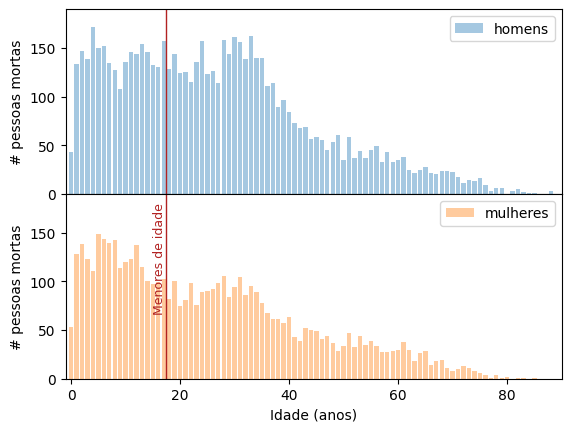

In [4]:
# Vendo os dados em um gráfico:
ag.graf_barra_2(n_mortos_df, ylabel='# pessoas mortas', ylim=[0,190], alpha=0.4)
pl.xlabel('Idade (anos)')
for i in range(1,3):
    pl.subplot(2, 1, i)
    pl.axvline(17.5, color='firebrick', linewidth=1)
pl.text(17.5, 70, 'Menores de idade', rotation=90, ha='right', color='firebrick', fontsize=9)
pl.show()

Os dados sobre a pirâmide etária se refere à toda a população de Gaza (estimativa de 2023) e tem a mesma forma. 
Os números de pessoas não são inteiros pois se trata de uma estimativa: 

In [5]:
# A cara dos dados:
piramide_df

,n_homens,n_mulheres
idade,,
0,27751.28,26097.97
1,27751.28,26097.97
2,27751.28,26097.97
3,27801.81,26149.60
4,27842.41,26195.69
...,...,...
88,218.69,304.05
89,179.82,253.37
90,138.94,202.69


Vamos ver a pirâmide etária em um gráfico:

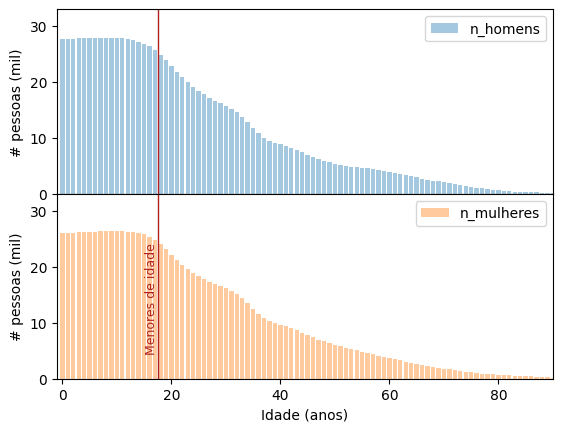

In [6]:
# Vendo os dados em um gráfico:
ag.graf_barra_2(piramide_df / 1000, ylabel='# pessoas (mil)', ylim=[0, 33], alpha=0.4)
pl.xlabel('Idade (anos)')
for i in range(1,3):
    pl.subplot(2, 1, i)
    pl.axvline(17.5, color='firebrick', linewidth=1)
pl.text(17.5, 5, 'Menores de idade', rotation=90, ha='right', color='firebrick', fontsize=9)
pl.show()

Já podemos notar que a distribuição das mortes por idade e sexo não é radicalmente diferente da distribuição da população como um todo.

## Criando um modelo estatístico motivado

Vamos elaborar um _modelo estatístico motivado pela realidade_ que descreva a distribuição das mortes em Gaza por idade e sexo. Vamos explicar o que queremos dizer 
com cada um desses termos:
* **Modelo:** é uma fórmula matemática que representa a ideia que temos da realidade. Essa fórmula quantifica o valor esperado para uma
certa quantidade chamada de _variável dependente_ (neste caso, o número de mortes) a partir do valor de _variáveis independentes_ (neste caso, a idade e o sexo).
Essa fórmula depende de suposições que fazemos a respeito da realidade, que são traduzidas para matemática e podem depender de outras quantidades, chamadas de _parâmetros_.
* **Estatístico:** este adjetivo está aqui para lembrar que esse modelo apenas quantifica uma tendência para a variável dependente. O valor real dessa variável possui uma
  componente aleatória -- isto é, que é impossível de prever pois depende de muitos fatores e acasos que são imprevisíveis.
* **Motivado pela realidade:**

In [7]:
def prob_morte(fg, pir_df, f_mulher, mH, sH, iminH, mM=None, sM=None, iminM=None, idade_min=0, idade_max=92, pymc=True):
    """
    Calcula as probabilidades de morte em um modelo de duas componentes 
    de ataques: gerais (indiscriminados) e focados em potenciais 
    combatentes.

    As mortes por ataques gerais são modeladas na proporção da pirâmide 
    etária e distribuição por sexo da população.

    As mortes por ataques focados são modeladas como uma distribuição 
    lognormal.

    Parâmetros
    ----------
    fg : float
        Fração das mortes decorrentes de ataques gerais.
    pir_df : DataFrame
        Pirâmide etária com fração da pop. total em cada idade (linha) e 
        sexo (coluna). Os índices devem ser idades em anos (int) e as 
        colunas devem ser 'f_homens' e 'f_mulheres'. Deve cobrir de 
        `idade_min` a `idade_max`.
    f_mulher : float
        Fração das mortes em ataques focados que são de mulheres. Se os 
        ataques só atingirem combatentes, essa deve ser a fração dos 
        combatentes que são mulheres.
    mH : float
        Média da distribuição de idade das mortes de homens por ataques 
        focados.
    sH : float
        Desvio padrão da distribuição de idade das mortes de homens por 
        ataques focados.
    iminH : float
        Idade mínima das mortes de homens decorrentes de ataques focados.
    mM : float
        Mesmo que `mH`, mas para mulheres. Se for None, copia o valor dos 
        homens.
    sM : float
        Mesmo que `sH`, mas para mulheres. Se for None, copia o valor dos 
        homens.
    iminM : float
        Mesmo que `iminH`, mas para mulheres. Se for None, copia o valor 
        dos homens.
    idade_min : int
        Idade mínima para o cálculo das probabilidades de morte.
    idade_max : int
        Idade máxima para o cálculo das probabilidades de morte.

    Retornos
    --------
    geral : array 1D de floats (2 * n_idade,)
        n_idade = (idade_max - idade_min + 1)
        Probabilidades de morte por ataques gerais para cada idade de 
        homens (geral[:n_idade]) e para cada idade de mulheres 
        (geral[n_idade:]).
    focado : array 1D de floats (2 * n_idade,)
        Probabilidades de morte por ataques focados para cada idade de 
        homens (focado[:n_idade]) e para cada idade de mulheres 
        (focado[n_idade:]).
    probs : array 1D de floats (2 * n_idade,)
        Probabilidades de morte do modelo completo para cada idade de 
        homens (probs[:n_idade]) e para cada idade de mulheres 
        (probs[n_idade:]).
    """
    
    # Usa o mesmo modelo focado para homens e mulheres se específico não for definido:
    if mM == None:
        mM = mH
    if sM == None:
        sM = sH
    if iminM == None:
        iminM = iminH    

    # Pirâmide etária (ataques gerais, indiscriminados):
    i   = np.arange(idade_min, idade_max + 1, dtype=np.int64)
    pir = np.concatenate((pir_df['f_homens'].loc[i].values, pir_df['f_mulheres'].loc[i].values))
        
    # Calcula parâmetros da PDF de morte enquanto alvo (ataque focado):
    muH, sigH, shiftH = su.to_lognormal_pars(mH, sH, -iminH)
    muM, sigM, shiftM = su.to_lognormal_pars(mM, sM, -iminM)
    
    # Quando rodamos o pyMC, precisamos usar algumas funções suas no lugar das do numpy:
    if pymc == True:
        # Homens:
        lnpdfH = su.lognormal_pdf(pm.math.clip(i + shiftH, 1e-12, 1e3), muH, sigH, 0)  # Prob. por idade.
        PfaltH = (1 - pm.math.sum(lnpdfH, keepdims=True)) / len(i)                     # Prob. faltante por erro de discretização da PDF
        alvosH = (1 - f_mulher) * (lnpdfH + PfaltH)                                    # Distribui a prob. igualmente (só é tudo bem se for pouca coisa)
        # Mulheres:
        lnpdfM = su.lognormal_pdf(pm.math.clip(i + shiftM, 1e-12, 1e3), muM, sigM, 0)
        PfaltM = (1 - pm.math.sum(lnpdfM, keepdims=True)) / len(i) 
        alvosM = f_mulher * (lnpdfM + PfaltM)
        # Ambos:
        alvos  = pm.math.concatenate((alvosH, alvosM))
    
        # Esse código deve ser igual ao de cima (trocando pm por np em alguns lugares):
    else:
        # Homens:
        lnpdfH = su.lognormal_pdf(np.clip(i + shiftH, 1e-12, 1e3), muH, sigH, 0)
        PfaltH = (1 - np.sum(lnpdfH, keepdims=True)) / len(i)
        alvosH = (1 - f_mulher) * (lnpdfH + PfaltH)
        # Mulheres:
        lnpdfM = su.lognormal_pdf(np.clip(i + shiftM, 1e-12, 1e3), muM, sigM, 0)
        PfaltM = (1 - np.sum(lnpdfM, keepdims=True)) / len(i) 
        alvosM = f_mulher * (lnpdfM + PfaltM)
        # Ambos:
        alvos  = np.concatenate((alvosH, alvosM))

    # Distribui os pesos das componentes
    geral  = fg * pir
    focado = (1 - fg) * alvos  
    # Modelo completo:
    probs  = geral + focado 
    
    return geral, focado, probs

## Modelo de duas componentes

Faremos um lognormal

In [8]:
pir_norm_df = pd.DataFrame()
pop_total   = piramide_df.sum().sum()
pir_norm_df['f_homens']   = piramide_df['n_homens']   / pop_total
pir_norm_df['f_mulheres'] = piramide_df['n_mulheres'] / pop_total

Abaixo, você pode mudar os parâmetros do modelo e ver a quantidade de mortes que ele prevê para cada idade e sexo:

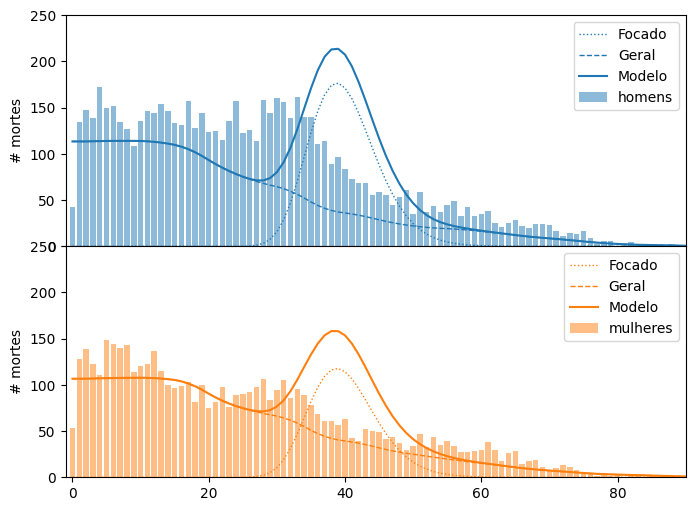

In [9]:
# Parâmetros do modelo:
f_ind = 0.70        # Fração das mortes que são causadas por ataques indiscriminados.
f_mulheres = 0.40   # Fração dos ataques focados que visam mulheres.
idade_media = 40    # Idade média das mortes causadas por ataques focados.
variacao_idade = 5  # Desvio padrão da idade das mortes causadas por ataques focados.
idade_minima   = 10 # Idade abaixo da qual a probabilidade da morte ser causada por ataque focado é zero.

# Calcula fração das mortes para cada idade e sexo:
geral, focado, probs = prob_morte(f_ind, pir_norm_df, f_mulheres, idade_media, variacao_idade, idade_minima, pymc=False)

# Cria gráfico que compara o modelo com os dados:
N_mortes = n_mortos_df[['homens', 'mulheres']].sum().sum()
pl.figure(figsize=(8,6))
ag.graf_barra_2(n_mortos_df[['homens', 'mulheres']], ylabel='# mortes', ylim=[0,250])
su.plot_esperado(N_mortes, focado, 'Focado', linewidth=1, linestyle='dotted')
su.plot_esperado(N_mortes, geral, 'Geral', linewidth=1, linestyle='--')
su.plot_esperado(N_mortes, probs, 'Modelo')

## MCMC para estimar parâmetros do modelo

In [10]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Usando MCMC para definir o prior das combatentes mulheres

In [11]:
# Dados:
total_ataques = 170
ataques_mulheres = 27
# Cria modelo
with pm.Model() as mulher_model:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    prob_mulher = pm.Flat('prior_mulher')
    
    # Cria Likelihood:
    #obs_counts = pair_counts.reshape(1, len(pair_counts))
    gen_counts = pm.Binomial('ataques_fem', n=total_ataques, p=prob_mulher, observed=[ataques_mulheres])

In [12]:
# Amostra modelo com MCMC:
with mulher_model:
    idata = pm.sample(draws=2500)
prior_mulher_sample = su.get_chains(idata, 'prior_mulher')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_mulher]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
# Aproxima a distribuição por uma Gaussiana:
g_mulher_m = prior_mulher_sample.mean()
g_mulher_s = prior_mulher_sample.std()
frase = 'Dado que, de 170 ataques, 27 foram realizados por mulheres, estimamos que a probabilidade de um ataque ser realizado por uma mulher é de {:.1f}% +/- {:.1f}%.'
print(frase.format(g_mulher_m * 100, g_mulher_s * 100))
x = np.arange(0.05,0.30, 0.002)
y = sc.stats.norm.pdf(x, g_mulher_m, g_mulher_s)

Dado que, de 170 ataques, 27 foram realizados por mulheres, estimamos que a probabilidade de um ataque ser realizado por uma mulher é de 16.3% +/- 2.8%.


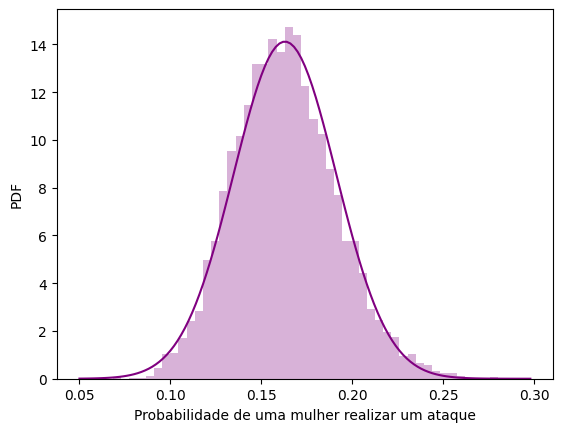

In [14]:
# Compara distribuição posterior obtida com MCMC com uma aproximação Gaussiana:
pl.hist(prior_mulher_sample, bins=50, color='purple', alpha=0.3, density=True)
pl.plot(x, y, color='purple')
pl.xlabel('Probabilidade de uma mulher realizar um ataque')
pl.ylabel('PDF')
pl.show()

### MCMC para o modelo geral

In [16]:
# Seleciona intervalo de idades que serão modeladas:
idade_min = 1
idade_max = 92
sel_mortos_df = n_mortos_df.loc[idade_min:idade_max] 
pir_sel_df = pir_norm_df.loc[idade_min:idade_max]

# Renormaliza probabilidades da pirâmide etária:
sel_prop_total = pir_sel_df.sum().sum()
pir_sel_df = pir_sel_df / sel_prop_total

# Organiza mortes observadas num vetor 1D:
conta_mortes  = np.concatenate((sel_mortos_df['homens'], sel_mortos_df['mulheres']))
# Calcula o total de mortes:
N_mortes = conta_mortes.sum()

# Cria modelo estatístico:
with pm.Model() as mortes_model:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    frac_geral  = pm.Uniform('fg', lower=0.01, upper=0.99)
    frac_mulher = pm.Normal('f_mulher', g_mulher_m, g_mulher_s*1.15)
    ln_mean     = pm.Uniform('foc_imedia', lower=20, upper=50)
    ln_dev      = pm.Uniform('foc_idev', lower=3, upper=40)
    ln_min      = pm.Uniform('foc_imin', lower=5, upper=25)

    # Calcula probabilidades de mortes por sexo e idade:
    g, f, probs = prob_morte(frac_geral, pir_sel_df, frac_mulher, ln_mean, ln_dev, ln_min, idade_min=idade_min, idade_max=idade_max)
    
    # Cria Likelihood:
    mortes_esp = pm.Multinomial('mortes_esp', n=N_mortes, p=probs, observed=conta_mortes)

In [17]:
# Amostra modelo com MCMC:
with mortes_model:
    idata = pm.sample(draws=5000)
# Coloca amostragem da prob. a posteriori dos parâmetros em um DataFrame:
chain_df = su.idata2df(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fg, f_mulher, foc_imedia, foc_idev, foc_imin]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.


## Análise dos resultados do modelo

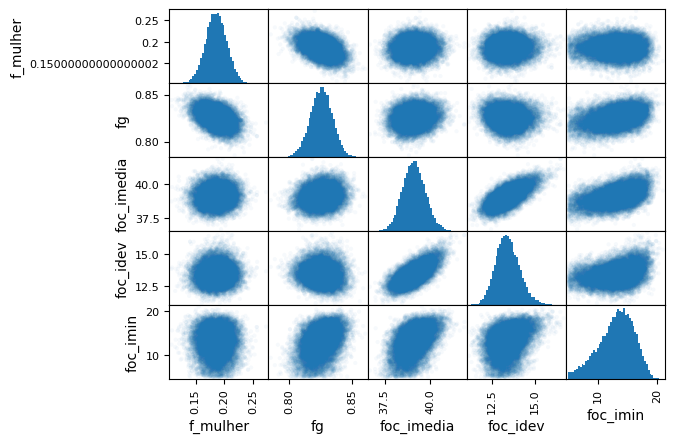

In [18]:
# Distribuição de probabilidades dos parâmetros do modelo, dadas as observações:
pd.plotting.scatter_matrix(chain_df, alpha=0.04, hist_kwds={'bins': 50})
pl.show()

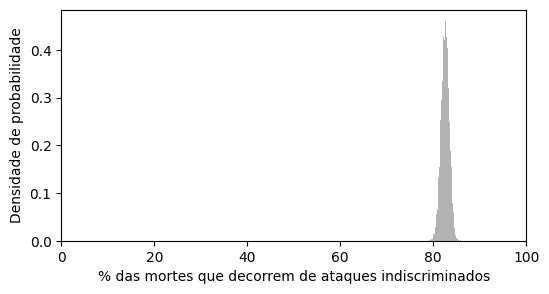

In [19]:
pl.figure(figsize=(6,3))
pl.hist(chain_df['fg'] * 100, bins=50, color='0.7', density=True)
pl.xlim([0,100])
pl.ylabel('Densidade de probabilidade')
pl.xlabel('% das mortes que decorrem de ataques indiscriminados')

pl.show()

In [20]:
# Pega valores esperados dos parâmetros do modelo:
best_fit = chain_df.mean().to_dict()

# Exibe valores esperados:
print(best_fit)

# Calcula prob. de morte de acordo com o modelo: 
geral, focado, probs = prob_morte(best_fit['fg'], pir_sel_df, best_fit['f_mulher'], best_fit['foc_imedia'], best_fit['foc_idev'], best_fit['foc_imin'], idade_min=idade_min, pymc=False)

{'f_mulher': 0.18571326484957704, 'fg': 0.825433489810871, 'foc_imedia': 39.10746023172204, 'foc_idev': 13.42611489599139, 'foc_imin': 13.100951463717232}


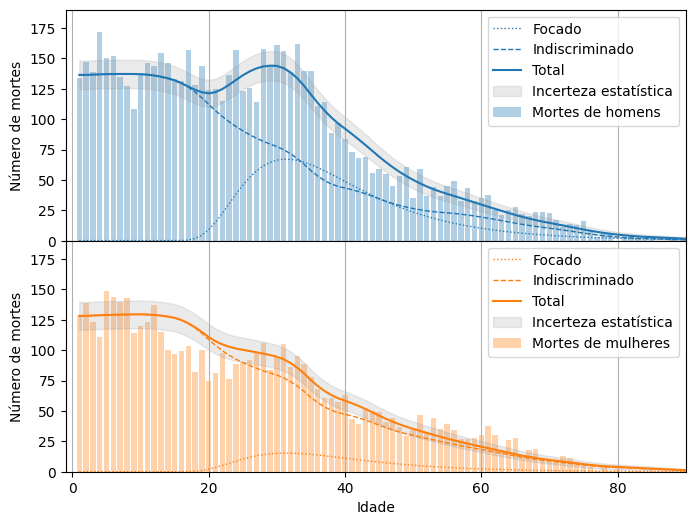

In [21]:
# Gráfico de mortes vs. modelo:
pl.figure(figsize=(8,6))
# Gráfico dos dados observados:
observacoes_df = sel_mortos_df[['homens', 'mulheres']].rename({'homens':'Mortes de homens', 'mulheres':'Mortes de mulheres'}, axis=1)
ag.graf_barra_2(observacoes_df, alpha=0.35, ylim=[0, 190], ylabel='Número de mortes', grid_axis='x')
# Gráficos do modelo:
su.plot_esperado(N_mortes, focado, 'Focado', linewidth=1, linestyle='dotted', idade_min=1)
su.plot_esperado(N_mortes, geral, 'Indiscriminado', linewidth=1, linestyle='--', idade_min=1)
su.plot_esperado(N_mortes, probs, 'Total', idade_min=1)
pl.xlabel('Idade')
# Coloca margem de erro estatístico (aproximado) do modelo:
for i in range(1,3):
    pl.subplot(2,1,i)
    y = probs[(i-1)*92:i*92] * N_mortes
    pl.fill_between(np.arange(1, 93), y - np.sqrt(y), y + np.sqrt(y), alpha=0.2, color='0.6', label='Incerteza estatística')
    pl.legend()
pl.show()

In [22]:
# Resumo em uma frase:
m_geral  = best_fit['fg'] * N_mortes
m_focado = (1 - best_fit['fg']) * N_mortes
print('Das {:,.0f} mortes registradas em hospitais, {:,.0f} são resultantes de ataques indiscriminados.'.format(N_mortes, m_geral))

Das 11,795 mortes registradas em hospitais, 9,736 são resultantes de ataques indiscriminados.


### Análise de resíduos

In [23]:
# Calcula os resíduos:
resid = conta_mortes - probs * N_mortes
resid_norm = resid / np.sqrt(probs * N_mortes)

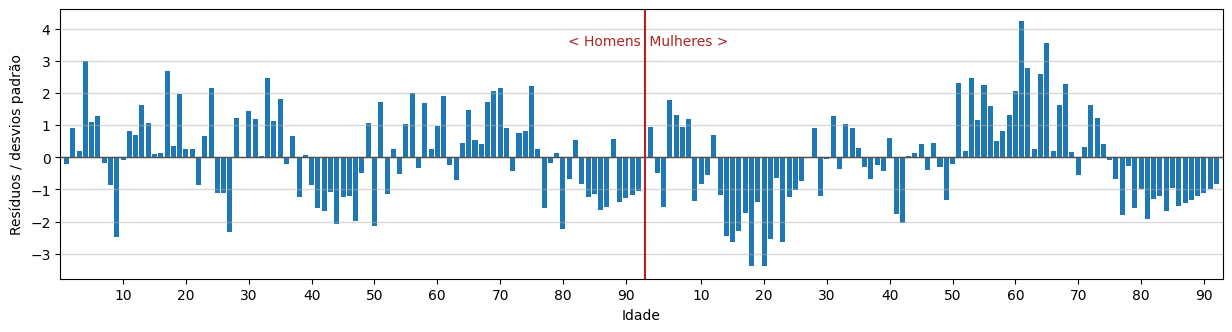

In [24]:
# Visualiza resíduos normalizados pelo desvio padrão:
pl.figure(figsize=(15,3.5))

# Plot:
bar_pos = np.arange(len(resid_norm))
pl.bar(bar_pos, resid_norm)

# Cria rótulos de idades:
n_idades = int(len(resid) / 2)
pos_h = bar_pos[:n_idades]
pos_m = bar_pos[n_idades:]
idades = np.arange(idade_min, idade_max + 1)
i_ini, i_fim, i_step = 9, 95, 10
xpos   = np.concatenate((pos_h[i_ini:i_fim:i_step], pos_m[i_ini:i_fim:i_step]))
xlabel = np.concatenate((idades[i_ini:i_fim:i_step], idades[i_ini:i_fim:i_step]))
pl.xticks(xpos, xlabel)

# Divisão homem/mulher:
pl.axvline(n_idades, color='firebrick')
pl.text(n_idades, 3.5, '< Homens ', ha='right', color='firebrick')
pl.text(n_idades, 3.5, ' Mulheres >', ha='left', color='firebrick')

# Formatação:
pl.xlim([-1, 2*92])
pl.axhline(0, color='0.3', linewidth=1)
pl.ylabel('Resíduos / desvios padrão')
pl.xlabel('Idade')
pl.grid(axis='y', linewidth=1, alpha=0.5)
pl.show()

Vemos acima que o modelo erra mais para as mulheres. Parte importante desse erro acontece na cauda da distribuição (após 50 anos). 
Trocar a distribuição lognormal por outra distribuição de cauda longa pode ajudar. 

### Teste do $\chi^2$ (Qui-quadrado)

In [25]:
chi2 = np.sum(resid_norm**2)

In [26]:
n_pontos_experimentais = len(probs)
n_parametros_modelo = 5
graus_liberdade = n_pontos_experimentais - n_parametros_modelo

chi2 / graus_liberdade

2.0332061604522944

In [27]:
# Valor-p:
sc.stats.distributions.chi2.cdf(chi2, graus_liberdade)

0.9999999999999895

O modelo não é perfeito: os desvios são maiores do que o esperado apenas por causa de flutuações estatísticas.